## Prerequisites


In [1]:
import dotenv

dotenv.load_dotenv()

True

In [ ]:
project_names = [
    "gender_female",
    "gender_male",
    "language_de",
    "language_en",
    "language_es",
    "language_fr",
    "language_it",
    "language_ja",
    "language_pt",
]
encoder_ids = [("mert_v1_95m", 768), ("whisper_large_v2", 1280)]


## 1. Create CAVs using LDA for Significance Test


In [ ]:
# training meta parameters
num_train_runs = 500
training_sample_count = 100

### Prepare Data


In [4]:
import os
import sys
import itertools

import s3fs
from cavmir.utils import (
    create_in_memory_test_dataloader,
    lda_one_cav,
    load_df_and_embeddings,
    store_cav_vector_array,
    store_evaluation_metrics,
)

s3 = s3fs.S3FileSystem(anon=False)

dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]


### Training



Fitting project: language_pt for encoder: mert_v1_95m
Iteration 1/5

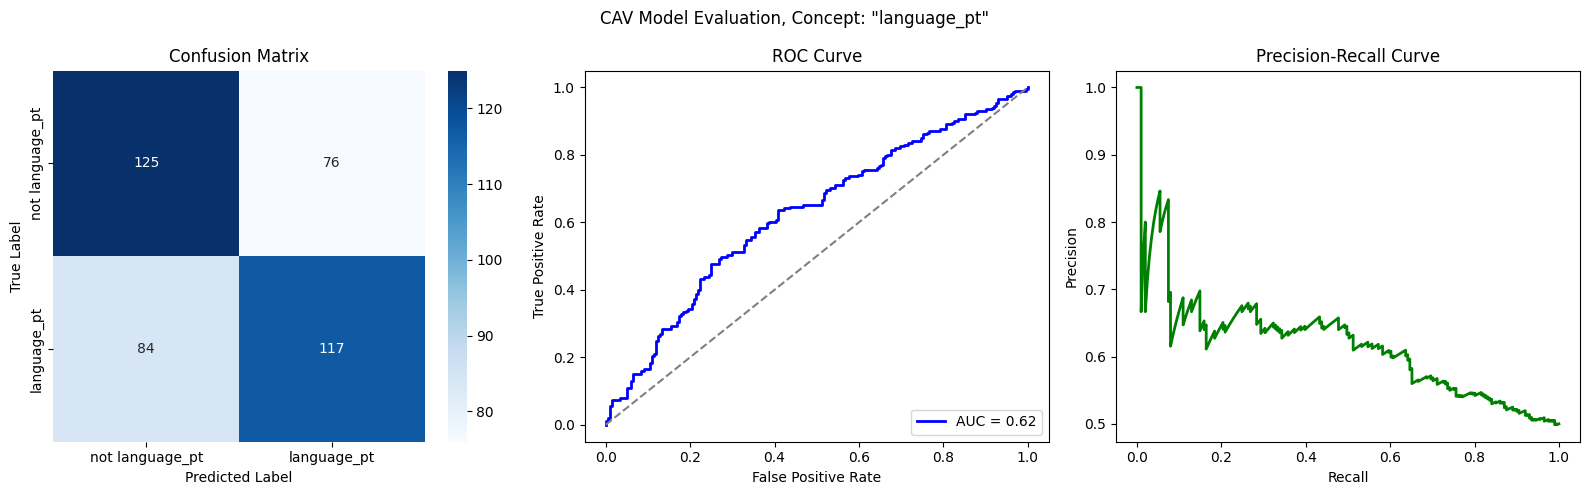

Iteration 2/5

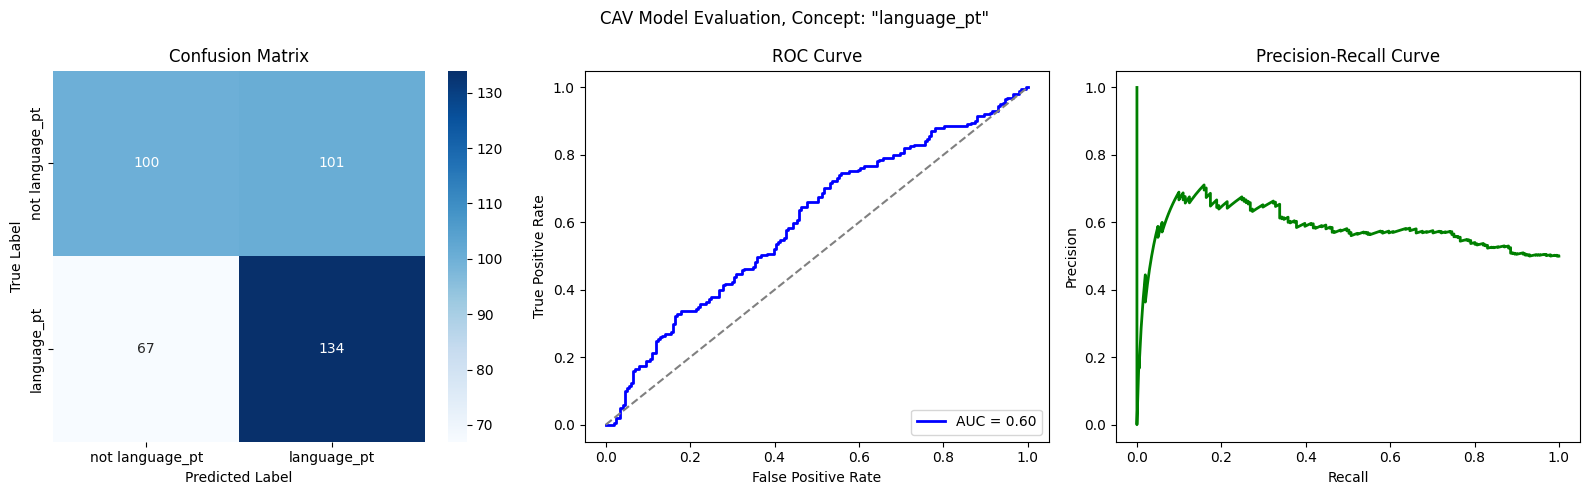

Iteration 3/5

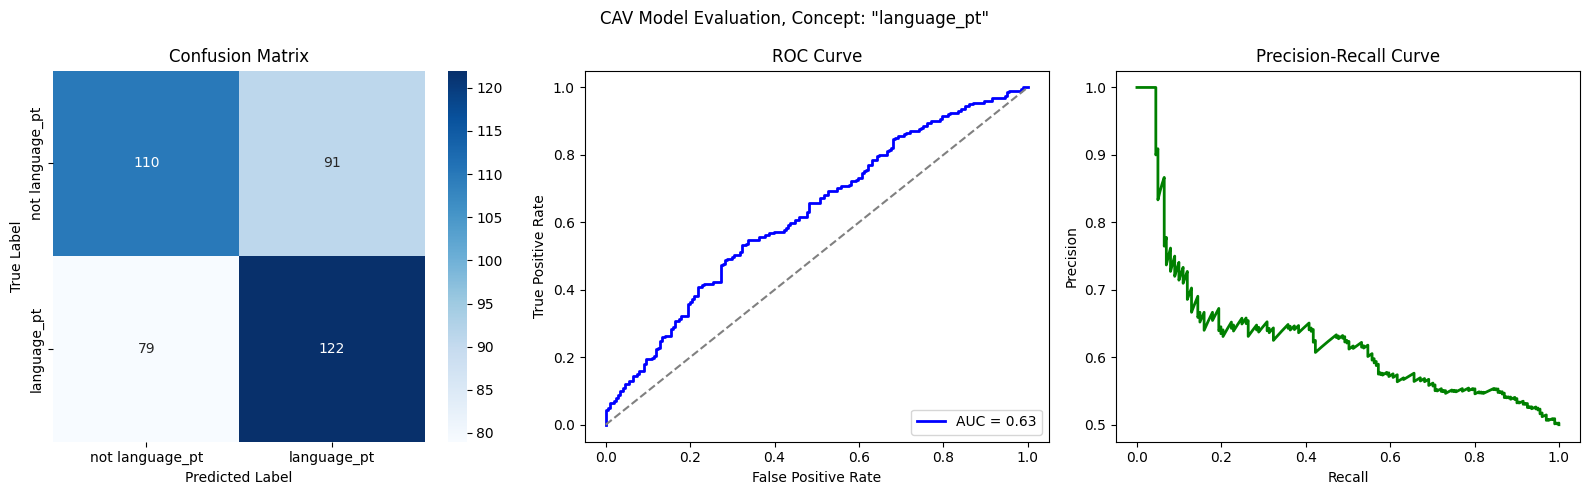

Iteration 4/5

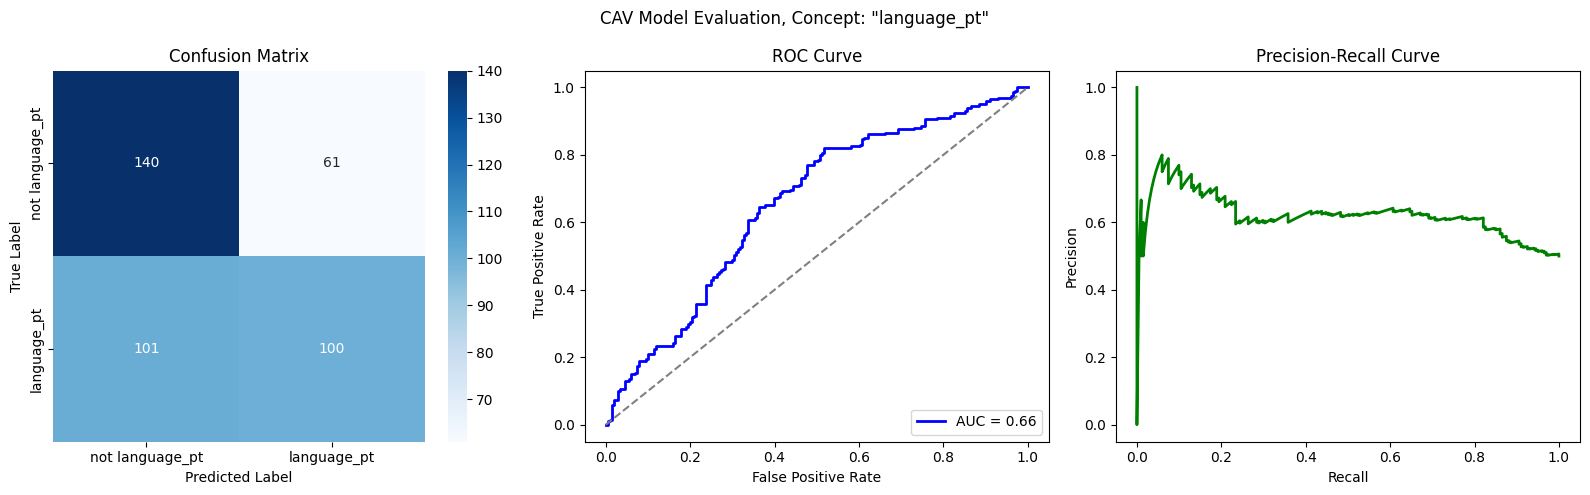

Iteration 5/5

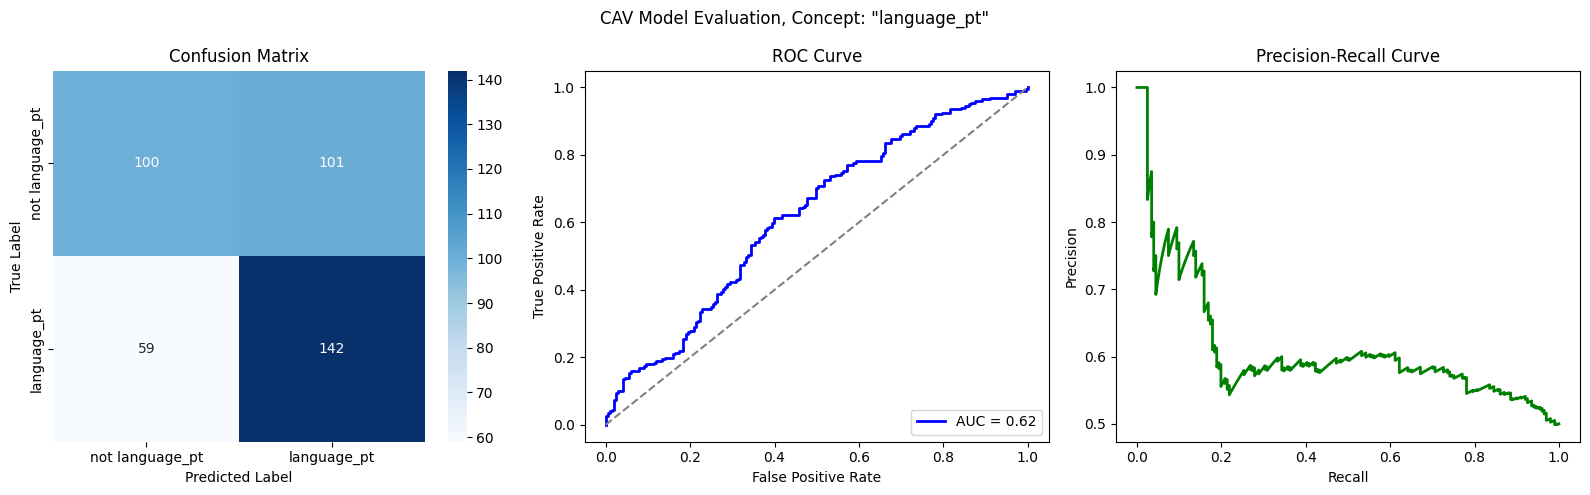


Fitting project: language_pt for encoder: whisper_large_v2
Iteration 1/5

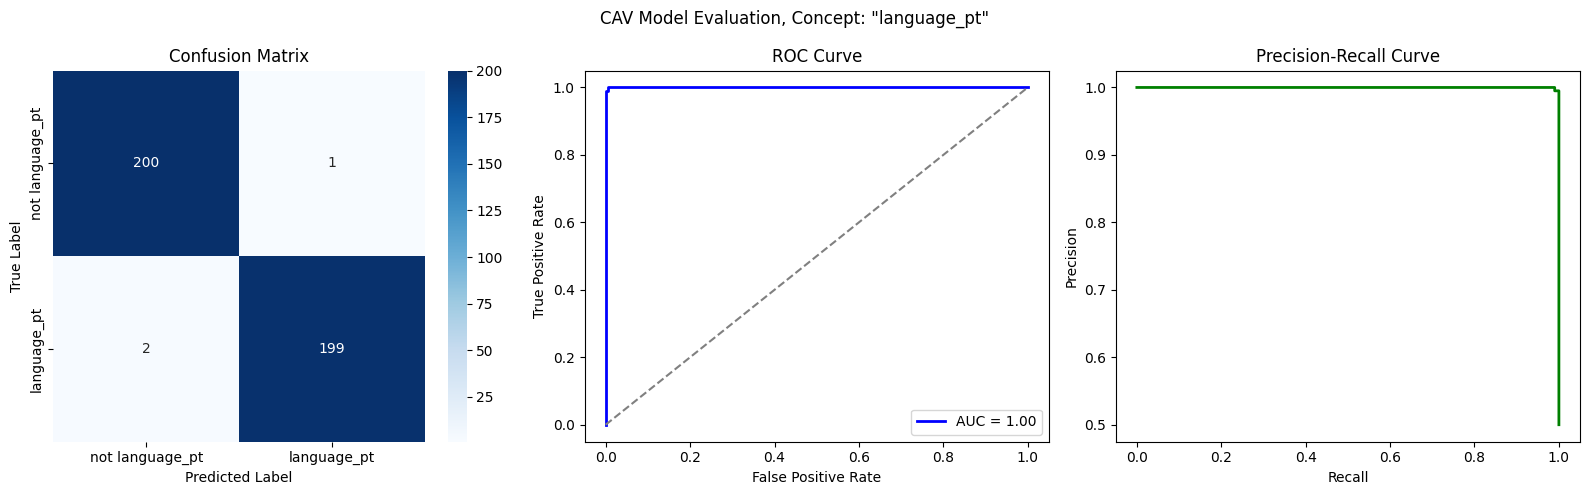

Iteration 2/5

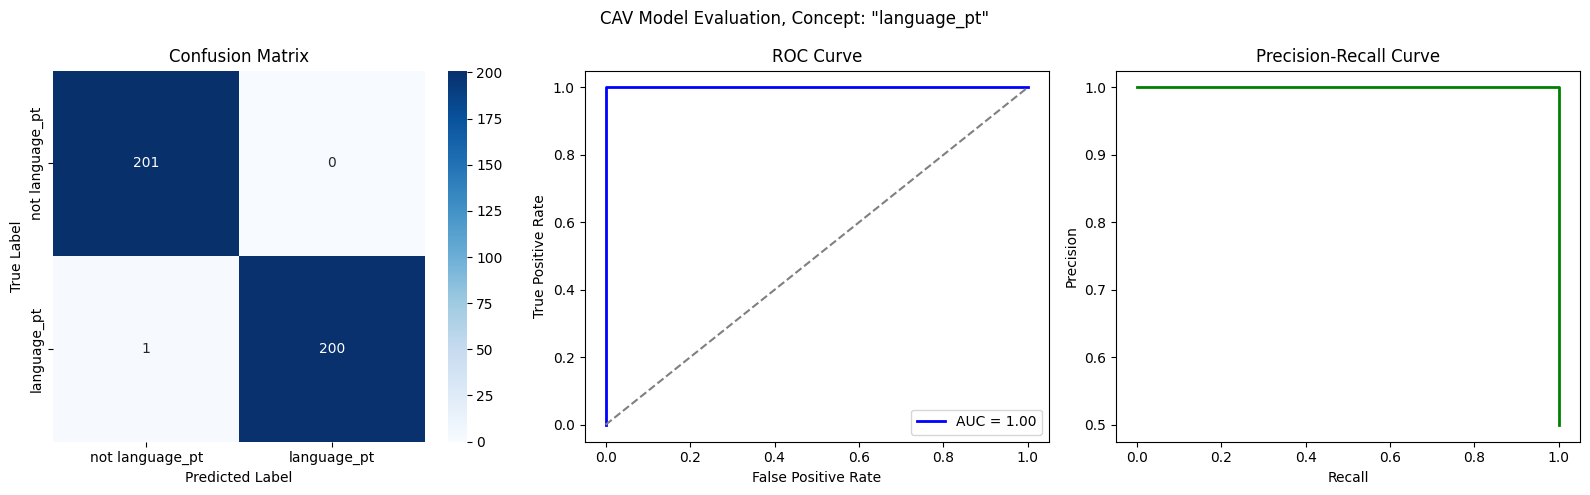

Iteration 3/5

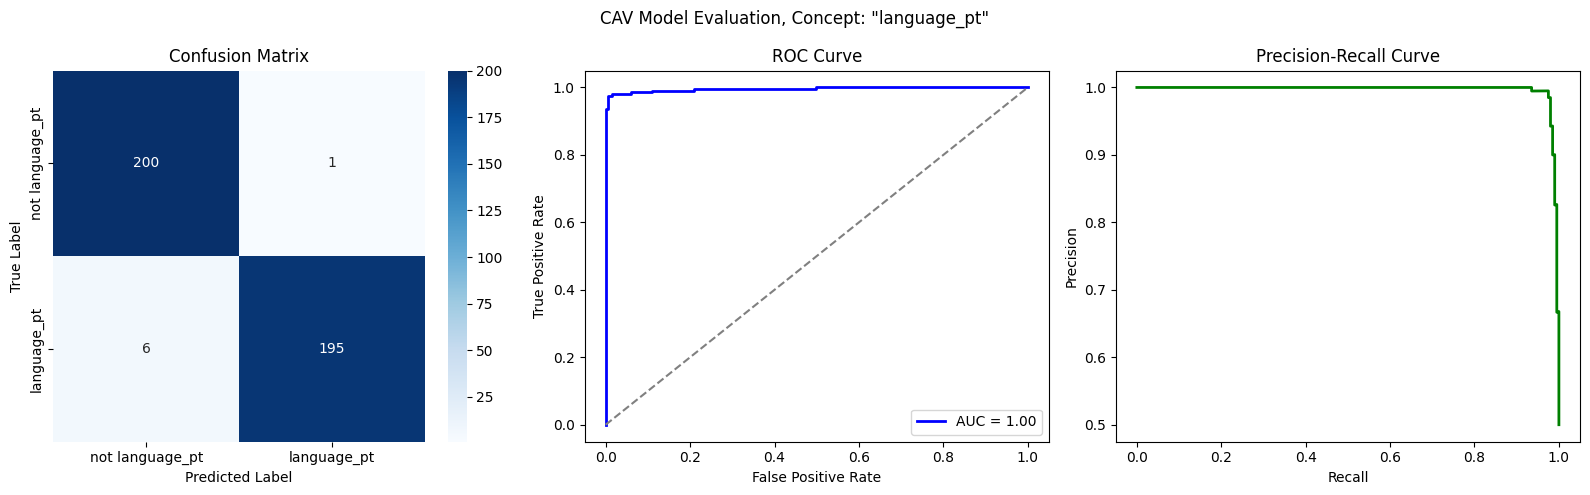

Iteration 4/5

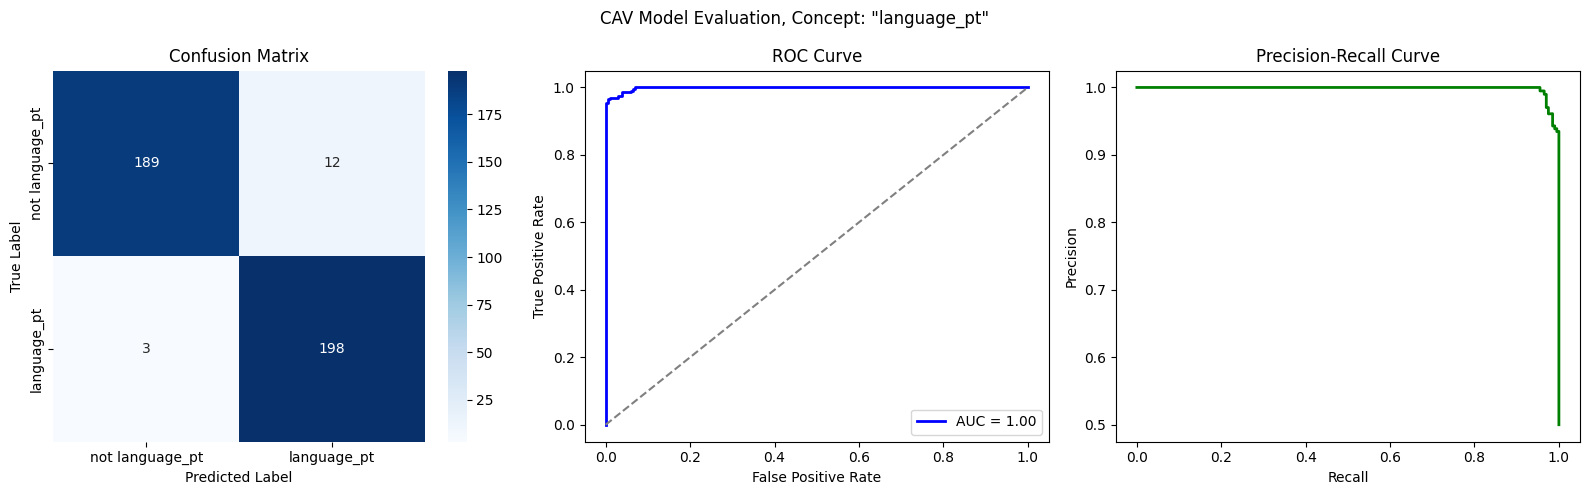

Iteration 5/5

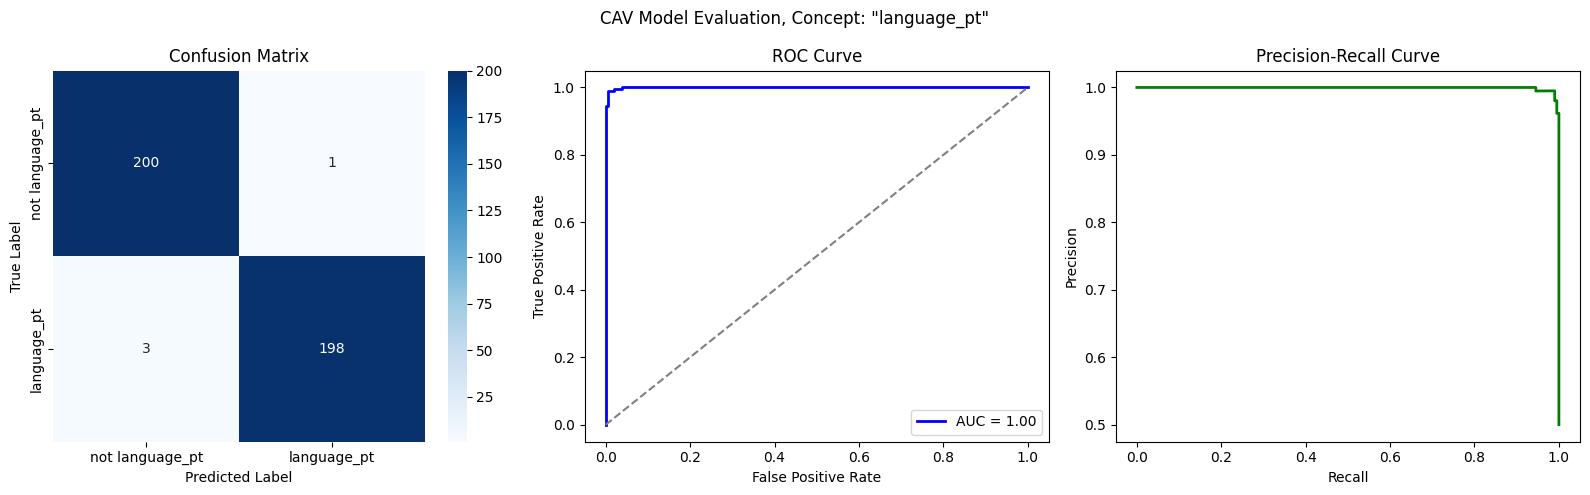

In [ ]:
train_variations = [*itertools.product(project_names, encoder_ids)]


for project_name, (encoder_id, embedding_dim) in train_variations:
    print(f"\nFitting project: {project_name} for encoder: {encoder_id}")
    df = load_df_and_embeddings(
        project_name, "train", encoder_id, dataset_prefix, embedding_prefix, s3
    )

    df_test = load_df_and_embeddings(
        project_name, "test", encoder_id, dataset_prefix, embedding_prefix, s3
    )

    test_dataloader = create_in_memory_test_dataloader(df_test)

    cav_vectors = []
    evaluation_metrics = []

    for i in range(num_train_runs):
        sys.stdout.write(f"\rIteration {i + 1}/{num_train_runs}")

        cav_vector, evaluation_metric = lda_one_cav(
            random_state=i,
            df=df,
            project_name=project_name,
            training_sample_count=training_sample_count,
            embedding_dim=embedding_dim,
            test_dataloader=test_dataloader,
            plot_evaluation=True,
        )

        cav_vectors.append(cav_vector)
        evaluation_metrics.append(evaluation_metric)

    store_cav_vector_array(
        cav_vectors, f"cav_ttest_{project_name}.npy", encoder_id, project_name
    )
    store_evaluation_metrics(
        evaluation_metrics,
        f"evaluation_metrics_ttest_{project_name}.json",
        encoder_id,
        project_name,
    )


## 2. Train CAV for Qualitative Tests


In [ ]:
train_val_split = 0.9

# training parameters
epochs = 500
batch_size = 128
learning_rate = 0.002
embedding_dim = 768
dropout_rate = 0.0

### Prepare Data


In [ ]:
import os

import pandas as pd
import s3fs
from cavmir.training.dataset import (
    create_dataloader_from_webdataset_path,
    create_webdataset,
)
from cavmir.utils import (
    append_embeddings_to_df,
    create_training_samples_from_df,
    store_cav_vector_array,
    store_evaluation_metrics,
    train_one_cav,
)

s3 = s3fs.S3FileSystem(anon=False)

dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]


In [ ]:
# load training set
df = pd.read_csv(os.path.join(dataset_prefix, f"train_dataset_{project_name}.csv"))
df = append_embeddings_to_df(df, embedding_prefix, encoder_id, s3)

training_sample_count = int(len(df) * train_val_split)
validation_sample_count = len(df) - training_sample_count


In [ ]:
validation_sample_count

537

In [ ]:
# create test set for evaluation
df_test = pd.read_csv(os.path.join(dataset_prefix, f"test_dataset_{project_name}.csv"))
df_test = append_embeddings_to_df(df_test, embedding_prefix, encoder_id, s3)

create_webdataset(
    create_training_samples_from_df(df_test),
    f"datasets/{encoder_id}_test_{project_name}.tar",
)

test_dataloader = create_dataloader_from_webdataset_path(
    f"datasets/{encoder_id}_test_{project_name}.tar", batch_size=batch_size
)

### Training


In [ ]:
cav_vector, evaluation_metric = train_one_cav(
    train_index=0,
    df=df,
    project_name=project_name,
    encoder_id=encoder_id,
    target_positive_class=target_positive_class,
    training_sample_count=training_sample_count,
    validation_sample_count=validation_sample_count,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    embedding_dim=embedding_dim,
    dropout_rate=dropout_rate,
    test_dataloader=test_dataloader,
)


store_cav_vector_array(cav_vector, f"cav_full_{project_name}.npy", project_name)
store_evaluation_metrics(
    evaluation_metric, f"evaluation_metrics_full_{project_name}.json", project_name
)


4833 537
Epoch 1/500
Epoch 1 Train Loss: 0.6953
Epoch 1 Validation Loss: 0.6983
Model saved to trainings/singer_age_decade_30/state_dict.pth
Epoch 11/500
Epoch 11 Train Loss: 0.6680
Epoch 11 Validation Loss: 0.6871
Model saved to trainings/singer_age_decade_30/state_dict.pth
Epoch 21/500
Epoch 21 Train Loss: 0.6578
Epoch 21 Validation Loss: 0.6804
Model saved to trainings/singer_age_decade_30/state_dict.pth
Epoch 31/500
Epoch 31 Train Loss: 0.6513
Epoch 31 Validation Loss: 0.6763
Model saved to trainings/singer_age_decade_30/state_dict.pth
Epoch 41/500
Epoch 41 Train Loss: 0.6465
Epoch 41 Validation Loss: 0.6737
Model saved to trainings/singer_age_decade_30/state_dict.pth
Epoch 51/500
Epoch 51 Train Loss: 0.6427
Epoch 51 Validation Loss: 0.6720
Model saved to trainings/singer_age_decade_30/state_dict.pth
Epoch 61/500
Epoch 61 Train Loss: 0.6395
Epoch 61 Validation Loss: 0.6709
Model saved to trainings/singer_age_decade_30/state_dict.pth
Epoch 71/500
Epoch 71 Train Loss: 0.6367
Epoch 71